In [12]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# SERVOMECANISMO COM INTEGRADOR

In [13]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [14]:
s = ctl.TransferFunction.s

G     = 104221.166952984/(1.0*s**2 + 793326.379032342*s - 1802772.14071392)
G_bkp = G
G

TransferFunction(array([104221.16695298]), array([ 1.00000000e+00,  7.93326379e+05, -1.80277214e+06]))

polos:  (-793328.651+0j) (2.272+0j)
zeros: 


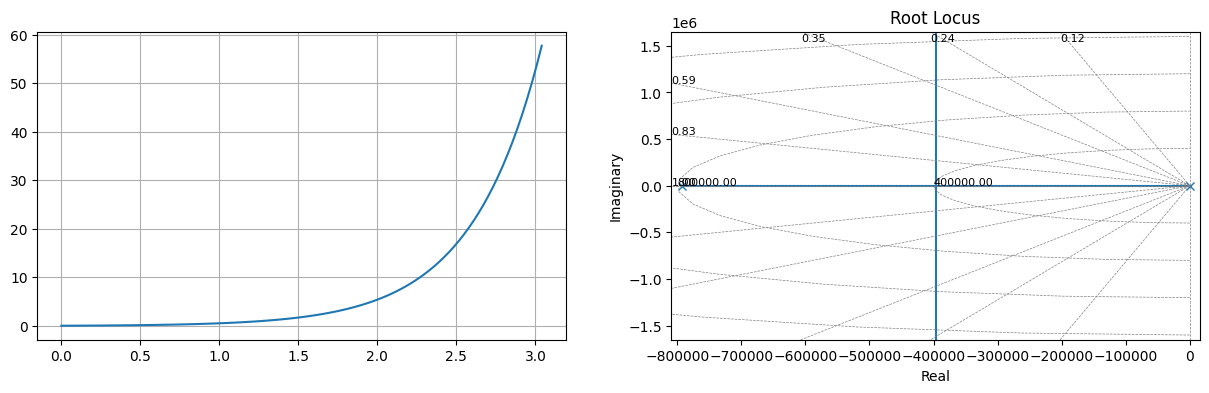

In [15]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# REQUISITOS DE CONTROLE

(0.4559498107691261, 4.386447702711552, -2.0 + 3.904*I)

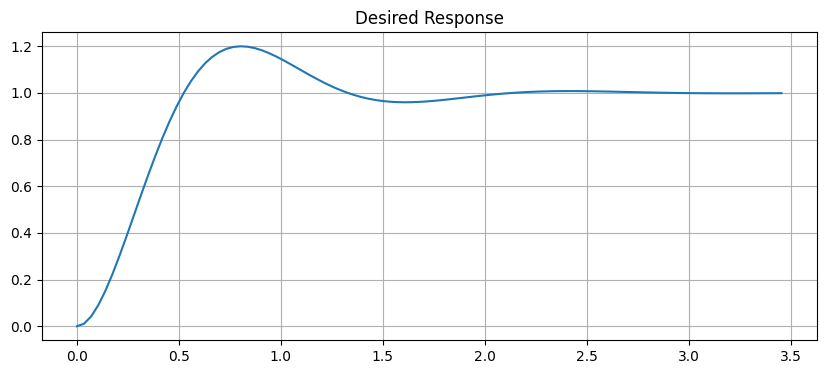

In [16]:
Ts = 2.0
UP = 0.2

zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
Wn = 4/(zeta*Ts)

s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)
G_desired = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

time, response = ctl.step_response(G_desired)
plt.figure(figsize=(10, 4))
plt.plot(time, response)
plt.title('Desired Response'), plt.grid()
(zeta, Wn, s_d)

In [17]:
s1 = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*1j
s2 = -zeta*Wn - Wn*np.sqrt(1-zeta**2)*1j
s3 = -5                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s4 = -5                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s5 = -5                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)

p = [np.round(val, 2) for val in [s1, s2]]
p

[(-2+3.9j), (-2-3.9j)]

# ESPAÇO DE ESTADOS
- Forma padrão (computacional)

In [18]:
matrix = ctl.tf2ss(G)
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D

display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[-793326.379032342, 1802772.14071392],
[              1.0,                0]])

Matrix([
[1.0],
[  0]])

Matrix([[0, 104221.166952984]])

Matrix([[0]])

- Forma variáveis de fase (convencional)

In [19]:
def getVariaveisFase(G):
    matrix = ctl.tf2ss(G)
    A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D
    
    n = A.shape[0]

    # Cria uma matriz P com elementos 1 na diagonal secundária
    P = np.fliplr(np.eye(n))

    # Calcula a inversa da matriz P
    P_inv = np.linalg.inv(P)

    # Realiza as operações para obter a forma de variáveis de fase
    A = P_inv @ A @ P
    B = P_inv @ B
    C = C @ P
    D = D
    
    return A, B, C, D

A, B, C, D = getVariaveisFase(G)
A, B, C, D = sp.Matrix(A), sp.Matrix(B), sp.Matrix(C), sp.Matrix(D)

display(A)
display(B)
display(C)
display(D)

Matrix([
[               0,               1.0],
[1802772.14071392, -793326.379032342]])

Matrix([
[  0],
[1.0]])

Matrix([[104221.166952984, 0]])

Matrix([[0]])

In [20]:
n = sp.shape(A)[0]
n

2

# CONTROLADOR

In [21]:
Ahat = sp.Matrix([
    [A,  sp.zeros(n, 1)],
    [-C, sp.zeros(1, 1)]
])

Bhat = sp.Matrix([
    [B],
    [sp.zeros(1, 1)]
])

Chat = sp.Matrix([
    [C, sp.zeros(1, 1)]
])

Dhat = D

display(Ahat)
display(Bhat)
display(Chat)
display(Dhat)

Matrix([
[                0,               1.0, 0],
[ 1802772.14071392, -793326.379032342, 0],
[-104221.166952984,                 0, 0]])

Matrix([
[  0],
[1.0],
[  0]])

Matrix([[104221.166952984, 0, 0]])

Matrix([[0]])

In [24]:
K = ctl.acker(Ahat, Bhat, p)
#K = ctl.place(A, B, p)

Ki = -1 * K[0][-1]
K  = np.array([K[0][:-1]]) # desconsiderando o últomo elemento que é o Ki

print(Ki)
sp.Matrix(K)

ValueError: System not reachable; pole placement invalid

In [ ]:
s = sp.symbols('s')
I = sp.eye(n+1) 
K = sp.Matrix(K)

In [ ]:
A_new = sp.Matrix([
    [A - B*K, B*Ki],
    [-C, sp.zeros(1, 1)]
])

B_new = sp.Matrix([
    [sp.zeros(n, 1)],
    [1]
])

C_new = sp.Matrix([
    [C, sp.zeros(1, 1)]
])

D_new = D

display(A_new)
display(B_new)
display(C_new)
display(D_new)

Matrix([
[       0,     1.0,       0,       0],
[       0,       0,     1.0,       0],
[-1940.75, -683.15, -107.21, 2401.25],
[    -1.0,       0,       0,       0]])

Matrix([
[0],
[0],
[0],
[1]])

Matrix([[1.0, 0, 0, 0]])

Matrix([[0]])

- Obtendo toda a função de transferência: $T_F = \frac{Y(s)}{U(s)} = C(sI - A)^{-1}B + D$

In [ ]:
T = C_new * (s*I - A_new).inv() * B_new + D_new
T = T[0]
T

1.0*(4.22093547200763e+15 - 1.0*s)/(1757807588550.81*s**4 + 188454551568532.0*s**3 + 1.20084625411848e+15*s**2 + 3.41146507747998e+15*s + 4.22093547200763e+15)

In [ ]:
G = sympyFunction(G)
G

1/(s**3 + 3*s**2 + 2*s)

- O controlador C é obtido usando a relação $T(s) = \frac{G(s)C(s)}{1 + C(s)C(s)}$

In [ ]:
C = T/(G*(1 - T))
C = C.expand().simplify().factor().cancel()
C = roundSympyFunction(C)
C

(0.0004*s**6 + 0.0489*s**5 + 0.4471*s**4 + 1.8673*s**3 + 4.2589*s**2 + 4.923*s + 2.1328)/(0.0024*s**5 + 0.0278*s**4 + 0.1637*s**3 + 0.538*s**2 + 1.0*s + 0.8619)

# RESPOSTA CONTROLADA

In [ ]:
s = ctl.TransferFunction.s
C = eval(str(C))
G = G_bkp

In [ ]:
G_ma = G*C
G_ma

TransferFunction(array([4.0000e-04, 4.8900e-02, 4.4710e-01, 1.8673e+00, 4.2589e+00,
       4.9230e+00, 2.1328e+00]), array([2.4000e-03, 3.5000e-02, 2.5190e-01, 1.0847e+00, 2.9414e+00,
       4.9379e+00, 4.5857e+00, 1.7238e+00, 0.0000e+00]))

In [ ]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([4.0000e-04, 4.8900e-02, 4.4710e-01, 1.8673e+00, 4.2589e+00,
       4.9230e+00, 2.1328e+00]), array([2.4000e-03, 3.5000e-02, 2.5230e-01, 1.1336e+00, 3.3885e+00,
       6.8052e+00, 8.8446e+00, 6.6468e+00, 2.1328e+00]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

polos:  (-1.848+2.975j) (-1.848-2.975j) (-1.576+1.912j) (-1.576-1.912j) (-2.342+0.519j) (-2.342-0.519j) (-2.051+0j) (-1+0j)
zeros:  (-112.692+0j) (-1.867+2.209j) (-1.867-2.209j) (-2.815+0j) (-2.009+0j) (-1+0j)


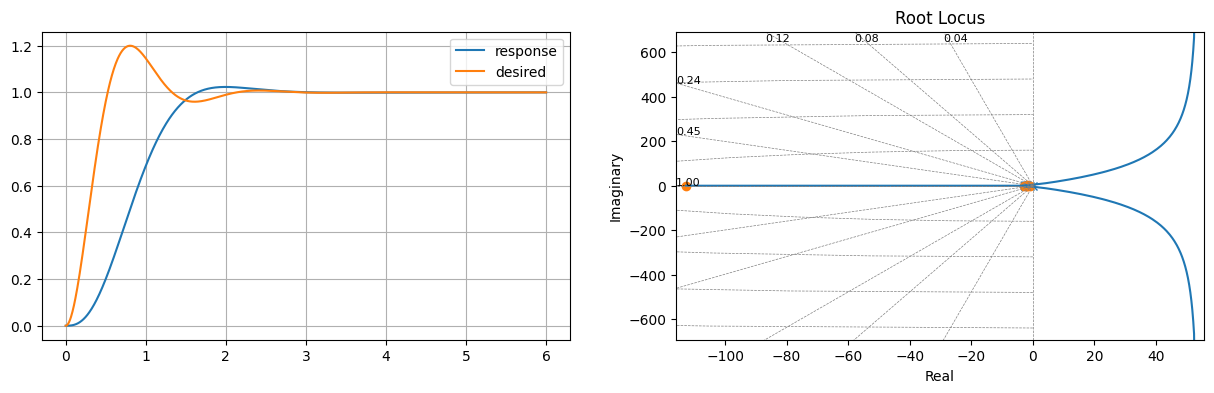

In [ ]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

tData = np.linspace(0, 3*Ts, 1000)
time, response = ctl.step_response(G_feedback, T=tData)
time, desired  = ctl.step_response(G_desired, T=tData)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(time, response, label='response')
plt.plot(time, desired, label='desired')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [ ]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.02325966847299646
valor de pico:  1.023315583671569
tempo de pico:  1.993993993993994
tempo de assentamento:  2.1921921921921923
valor final:  1.000054644192765
erro:  5.464419276490773e-05


# APLICANDO VÁRIOS STEPS

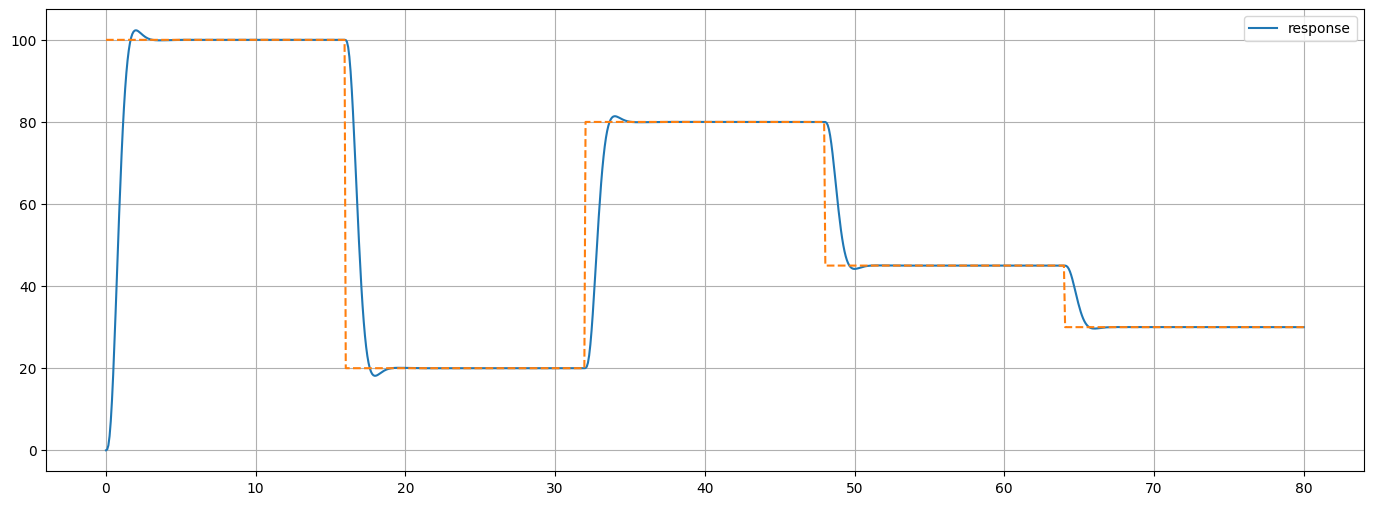

In [ ]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 80, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()